In [11]:
# importing necessary libraries
import requests 
from bs4 import BeautifulSoup 
import csv 
import pandas as pd 
import re

# creating a data frame from the csv file
df = pd.read_csv("../data/data.csv") 
display("All the 356 PR Links:")
display(df['Pull Request'])

'All the 356 PR Links:'

0               https://github.com/apache/juneau/pull/16
1      https://github.com/apache/incubator-druid/pull...
2      https://github.com/apache/incubator-gobblin/pu...
3              https://github.com/apache/ambari/pull/760
4               https://github.com/apache/nutch/pull/234
                             ...                        
351           https://github.com/facebook/jest/pull/6650
352          https://github.com/facebook/react/pull/4447
353           https://github.com/facebook/jest/pull/7385
354           https://github.com/facebook/jest/pull/2621
355          https://github.com/facebook/react/pull/4787
Name: Pull Request, Length: 356, dtype: object

In [12]:
# Filtering only the PR of Apache Company Repository
apacheDataSet = df[df['Repo'].str.contains('/apache')]

In [13]:
# Filtering only the PR of Mozilla Company Repository
mozillaDataSet = df[df['Repo'].str.contains('/mozilla')]

In [14]:
# Filtering only the PR of Google Company Repository
googleDataSet = df[df['Repo'].str.contains('/google')]

In [15]:
# Filtering only the PR of Facebook Company Repository
facebookDataSet = df[df['Repo'].str.contains('/facebook')]
# display(googleDataSet)
# display(googleDataSet.count())

In [16]:
# Using only Apache PR's
pullRequestList=apacheDataSet['Pull Request'].values.tolist()

In [17]:
print("Length of PR's of Apache:")
print(len(pullRequestList))

Length of PR's of Apache:
88


In [18]:
dictw = {'title':[], 
        'comment':[]
       } 
resultDF = pd.DataFrame(dictw) 

In [19]:
commitsList=[]
filesChangedList = []
green = []
red = []

for i in range(len(pullRequestList)):
    URL = pullRequestList[i]
    r = requests.get(URL)
    soup = BeautifulSoup(r.content, 'html.parser') 
    mainTitle = soup.find('h1', attrs = {'class':'gh-header-title mb-2 lh-condensed f1 mr-0 flex-auto break-word'})
    comment = soup.find('div',attrs={'class':'edit-comment-hide'})
    
    commits = soup.find('span', attrs = {'class':'js-updateable-pull-request-commits-count Counter'})
    files_changed = soup.find('span', attrs = {'id':'files_tab_counter'})
    
    if commits:
        commitsList.append(commits.get_text())
    else:
        commitsList.append(0)
        
    if files_changed:
        filesChangedList.append(files_changed.get_text())
    else:
        filesChangedList.append(0)
    
    code_churn_data = soup.find('span', attrs = {'id':'diffstat'})
#     print(code_churn_data)
    if code_churn_data:
        for i in code_churn_data.findAll('span', attrs = {'class':'text-green'}):
#             print(re.sub(r'\D', '', i.text))
            green.append(re.sub(r'\D', '', i.text))
        for j in code_churn_data.findAll('span', attrs = {'class':'text-red'}):
            red.append(re.sub(r'\D', '', j.text))
#             print(re.sub(r'\D', '', j.text))
    else:
        green.append(0)
        red.append(0)

        
    heading=""
    if mainTitle:
        for row in mainTitle.findAll('span', attrs = {'class':'js-issue-title'}):
            heading=row.get_text()
            for roww in comment.findAll('td', attrs = {'class':'d-block comment-body markdown-body js-comment-body'}):
                finalComment=""
                for rowww in roww.find_all(['p', 'li']):
                    finalComment=finalComment+rowww.get_text()+'.'
            resultDF.loc[len(resultDF.index)] = [heading, finalComment] 


In [20]:
# print(commitsList)
# print(len(commitsList))
resultDF['num_commits']  = list(map(int, commitsList)) 
# df_marks['num_commits'] = commitsList

In [21]:
# print(filesChangedList)
# print(len(filesChangedList))
# df_marks['files_changed'] = filesChangedList
resultDF['files_changed']  = list(map(int, filesChangedList)) 

In [22]:
greenlist = list(map(int, green)) 
redlist = list(map(int, red)) 
# print(redlist)
# print(greenlist)

In [23]:
res_list = [] 
for i in range(0, len(green)): 
    res_list.append(greenlist[i] + redlist[i]) 

In [24]:
resultDF['code_churn'] = res_list

In [25]:
display(resultDF)

,title,comment,num_commits,files_changed,code_churn
0,\n Added LN ST PE vars to svl-core\n,This is related to last mail thread..$LN = for...,4,7,387
1,\n Add SQL REGEXP_EXTRACT function; add...,Syntax is the same as Hive/Presto's REGEXP_EXT...,2,8,252
2,\n Initial pull request for the Gobblin...,This pull request contains the changes for Mut...,19,18,1384
3,\n [AMBARI-23334] Using the proper regu...,The regular expression we use to validate --ss...,3,2,28
4,\n NUTCH-2394 Fix of bugs detected by s...,String.trim() without assignment.avoid strings...,2,0,0
...,...,...,...,...,...
83,\n CB-14198: (all) Fix bug when running...,This is an improved version of #11 PR created ...,9,2,21
84,\n Cpp client: add PatternMultiTopicsCo...,In PR #1279 and #1298 we added regex based sub...,3,21,1064
85,\n SLING-7741 - org.apache.sling.xss.im...,implemented the URI grammar from RFC3986 as a ...,3,0,0
86,\n [sql lab] extract Hive error message...,So pyhive returns an exception object with a s...,2,2,27


In [26]:
comment_list=resultDF['comment'].values.tolist()

In [27]:
title_list=resultDF['title'].values.tolist()

In [103]:
rootCause=[]
# regExString=["regex","regular expression"]
# apiURLString=["api","url"]
for index in range(len(comment_list)):
    if "regex" in comment_list[index] or "regex" in title_list[index]: 
        rootCause.append("regEx")
    elif "regular expression" in comment_list[index] or "regex" in title_list[index]:
        rootCause.append("regEx")
    elif "URL" in comment_list[index] or "regex" in title_list[index]:
        rootCause.append("API")
    elif "API" in comment_list[index] or "regex" in title_list[index]:
        rootCause.append("API")
    else:
        rootCause.append("Other")

In [104]:
resultDF['Root Cause'] = rootCause 

In [105]:
resultDF

,title,comment,num_commits,files_changed,code_churn,Root Cause
0,\n Added LN ST PE vars to svl-core\n,This is related to last mail thread..$LN = for...,4,7,387,regEx
1,\n Add SQL REGEXP_EXTRACT function; add...,Syntax is the same as Hive/Presto's REGEXP_EXT...,2,8,252,regEx
2,\n Initial pull request for the Gobblin...,This pull request contains the changes for Mut...,19,18,1384,regEx
3,\n [AMBARI-23334] Using the proper regu...,The regular expression we use to validate --ss...,3,2,28,regEx
4,\n NUTCH-2394 Fix of bugs detected by s...,String.trim() without assignment.avoid strings...,2,7,28,regEx
...,...,...,...,...,...,...
83,\n CB-14198: (all) Fix bug when running...,This is an improved version of #11 PR created ...,9,2,21,regEx
84,\n Cpp client: add PatternMultiTopicsCo...,In PR #1279 and #1298 we added regex based sub...,3,21,1064,regEx
85,\n SLING-7741 - org.apache.sling.xss.im...,implemented the URI grammar from RFC3986 as a ...,3,0,0,regEx
86,\n [sql lab] extract Hive error message...,So pyhive returns an exception object with a s...,2,2,27,regEx


In [106]:
manifestation=[]
newFeatureStringList=["add","ADD"]
incorrectBehaviourStringList=["proper","modified","fixed","fix","change","changing","changes","expanding regex","expand"]
compileErrorStringList=["detected","reworked","confusing"]
badsmellrStringList=["refactor","update","updating","parse","Replace","better"]
incorrectComputationStringList=["assertion"]

for index in range(len(comment_list)):
    if any(x in comment_list[index] for x in newFeatureStringList) or any(x in title_list[index] for x in newFeatureStringList):
        manifestation.append("new feature")
    elif any(x in comment_list[index] for x in incorrectComputationStringList) or any(x in title_list[index] for x in incorrectComputationStringList):
         manifestation.append("incorrect computation")
    elif any(x in comment_list[index] for x in badsmellrStringList) or any(x in title_list[index] for x in badsmellrStringList):
         manifestation.append("bad smell")
    elif any(x in comment_list[index] for x in compileErrorStringList) or any(x in title_list[index] for x in compileErrorStringList):
        manifestation.append("compile error")
    elif any(x in comment_list[index] for x in incorrectBehaviourStringList) or any(x in title_list[index] for x in incorrectBehaviourStringList):
         manifestation.append("incorrect behavior")
    else:
        manifestation.append("other failure")

In [107]:
resultDF['Manifestation'] = manifestation 

In [109]:
category=[]
acceptingInvalidStringList=["Bugfix for regex","Fix integration test script","SSP mail form"]
incorrectExtractionStringList=["StringExpander regex","fix whitelist","Fix greedy regex"]
dataProcessingStringList=["Add helper script","Add sec","Enabling extraction","Add custom context"]
badSmellStringList=["Refactor","Rename","Optimize"]
regexConfigStringList=["configurable","config"]
regexLikeImplStringList=["REGEXP_EXTRACT","Regex replacement","regex filter"]
rejectingValidStringList=["better regex","RegEx pattern should be updated","replaces the regex"]
codeSmelldStringList=["regex pattern","replace by regular","Remove"]


for index in range(len(comment_list)):
    if any(x in comment_list[index] for x in acceptingInvalidStringList) or any(x in title_list[index] for x in acceptingInvalidStringList):
        category.append("accepting invalid strings(T2)")
    elif any(x in comment_list[index] for x in incorrectExtractionStringList) or any(x in title_list[index] for x in incorrectExtractionStringList):
        category.append("incorrect extraction")
    elif any(x in comment_list[index] for x in dataProcessingStringList) or any(x in title_list[index] for x in dataProcessingStringList):
        category.append("data processing")
    elif any(x in comment_list[index] for x in badSmellStringList) or any(x in title_list[index] for x in badSmellStringList):
        category.append("bad smells")
    elif any(x in comment_list[index] for x in regexConfigStringList) or any(x in title_list[index] for x in regexConfigStringList):
        category.append("regex configuration entry")
    elif any(x in comment_list[index] for x in regexLikeImplStringList) or any(x in title_list[index] for x in regexLikeImplStringList):
        category.append("regex like implementation")
    elif any(x in comment_list[index] for x in rejectingValidStringList) or any(x in title_list[index] for x in rejectingValidStringList):
        category.append("rejecting valid strings (T1)")
    elif any(x in comment_list[index] for x in codeSmelldStringList) or any(x in title_list[index] for x in codeSmelldStringList):
        category.append("code smells")
    else:
        category.append(" ")

In [110]:
resultDF['Category'] = category 

In [111]:
#Storing the executed data in a result.csv file.
resultDF.to_csv(r'../data/new_result.csv', sep=',', mode='a')

In [144]:
# code for Mann-Whitney U test to test the number of commits in both original and obtained data set
from scipy.stats import mannwhitneyu 
batch_1 =resultDF['num_commits']
batch_2 =df['num_commits']
  
# perform mann whitney test 
stat, p_value = mannwhitneyu(batch_1, batch_2) 
print('Statistics=%.2f, p=%.2f' % (stat, p_value)) 
# Level of significance 
alpha = 0.001
# conclusion 
if p_value < alpha: 
    print('Significant difference between two samples') 
else: 
    print('No significant difference between two samples')

Statistics=13265.00, p=0.01
No significant difference between two samples


In [145]:
# code for Mann-Whitney U test to test the lines of code in both original and obtained data set
from scipy.stats import mannwhitneyu 
# Take batch 1 and batch 2 data as per above example 
batch_1 =resultDF['code_churn']
batch_2 =df['code_churn']
  
# perform mann whitney test 
stat, p_value = mannwhitneyu(batch_1, batch_2) 
print('Statistics=%.2f, p=%.2f' % (stat, p_value)) 
# Level of significance 
alpha = 0.001
# conclusion 
if p_value < alpha: 
    print('Significant difference between two samples') 
else: 
    print('No significant difference between two samples')

Statistics=8699.00, p=0.00
Significant difference between two samples


In [146]:
# code for Mann-Whitney U test to test the files changed in both original and obtained data set
from scipy.stats import mannwhitneyu 
# Take batch 1 and batch 2 data as per above example 
batch_1 =resultDF['files_changed']
batch_2 =df['files_changed']
  
# perform mann whitney test 
stat, p_value = mannwhitneyu(batch_1, batch_2) 
print('Statistics=%.2f, p=%.2f' % (stat, p_value)) 
# Level of significance 
alpha = 0.001
# conclusion 
if p_value < alpha: 
    print('Significant difference between two samples') 
else: 
    print('No significant difference between two samples')

Statistics=8488.50, p=0.00
Significant difference between two samples


In [147]:
import matplotlib.pyplot as plt

def generate_distribution_histogram(dataframe, 
                                    column_name, 
                                    title, x_axis_label, y_axis_label,
                                    label_name,
                                    number_bins = 15):
    plt.hist(dataframe[column_name], bins = number_bins, label = label_name)
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend(loc='upper right')



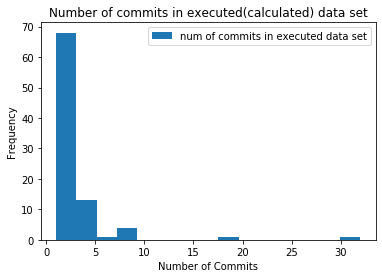

In [152]:
df_result =resultDF
df_original =df
generate_distribution_histogram(df_result, 
                                'num_commits',
                                title = 'Number of commits in executed(calculated) data set',
                                x_axis_label = 'Number of Commits',
                                y_axis_label = 'Frequency',
                                label_name = 'num of commits in executed data set')


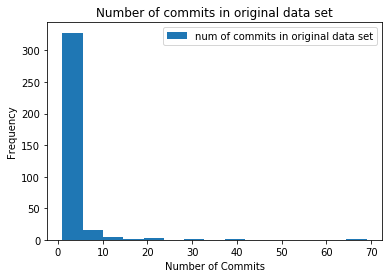

In [149]:
generate_distribution_histogram(df_original, 
                                'num_commits',
                                title = 'Number of commits in original data set',
                                x_axis_label = 'Number of Commits',
                                y_axis_label = 'Frequency',
                                label_name = 'num of commits in original data set')

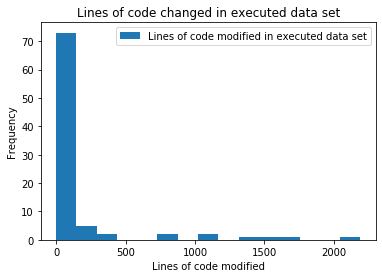

In [153]:
generate_distribution_histogram(df_result, 
                                'code_churn',
                                title = 'Lines of code changed in executed data set',
                                x_axis_label = 'Lines of code modified',
                                y_axis_label = 'Frequency',
                                label_name = 'Lines of code modified in executed data set')

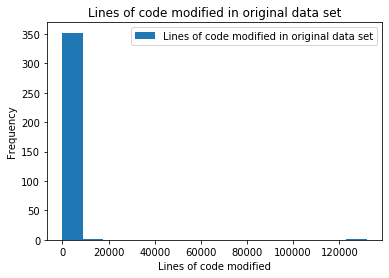

In [154]:
generate_distribution_histogram(df_original, 
                                'code_churn',
                                title = 'Lines of code modified in original data set',
                                x_axis_label = 'Lines of code modified',
                                y_axis_label = 'Frequency',
                                label_name = 'Lines of code modified in original data set')